In [3]:
from keras.applications import VGG16
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.core import Dense
from keras.models import Model
from keras.layers import Input
from keras.optimizers import SGD
from keras.utils.vis_utils import plot_model
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import cv2
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import os

Using TensorFlow backend.


In [3]:
img_size = 224
batch_size = 64
EPOCHS = 80

In [4]:
labels = pd.read_csv('../MTLData/csv/data.csv',dtype=str,delimiter=",")
labels = labels.sample(frac=1).reset_index(drop=True) #Shuffle data
labels['Image'] = labels['Image'].astype(str)  

In [5]:
labels['Image'].head(100)

0     3110_32
1     3227_27
2     3197_23
3      3320_2
4     3157_33
       ...   
95    3261_19
96    3238_12
97    3219_17
98    3260_27
99    3109_11
Name: Image, Length: 100, dtype: object

In [6]:
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(img_size, img_size, 3)))

flatLayer = baseModel.output
sharedLayer = Flatten(name="flatten")(flatLayer)
task1 = Dense(512, activation="relu")(sharedLayer)
task1 = Dense(10, activation="softmax",name='PFR')(task1)
task2 = Dense(512, activation="relu")(sharedLayer)
task2 = Dense(5, activation="softmax",name='FT')(task2)
model3 = Model(inputs=baseModel.input, outputs=[task1,task2])

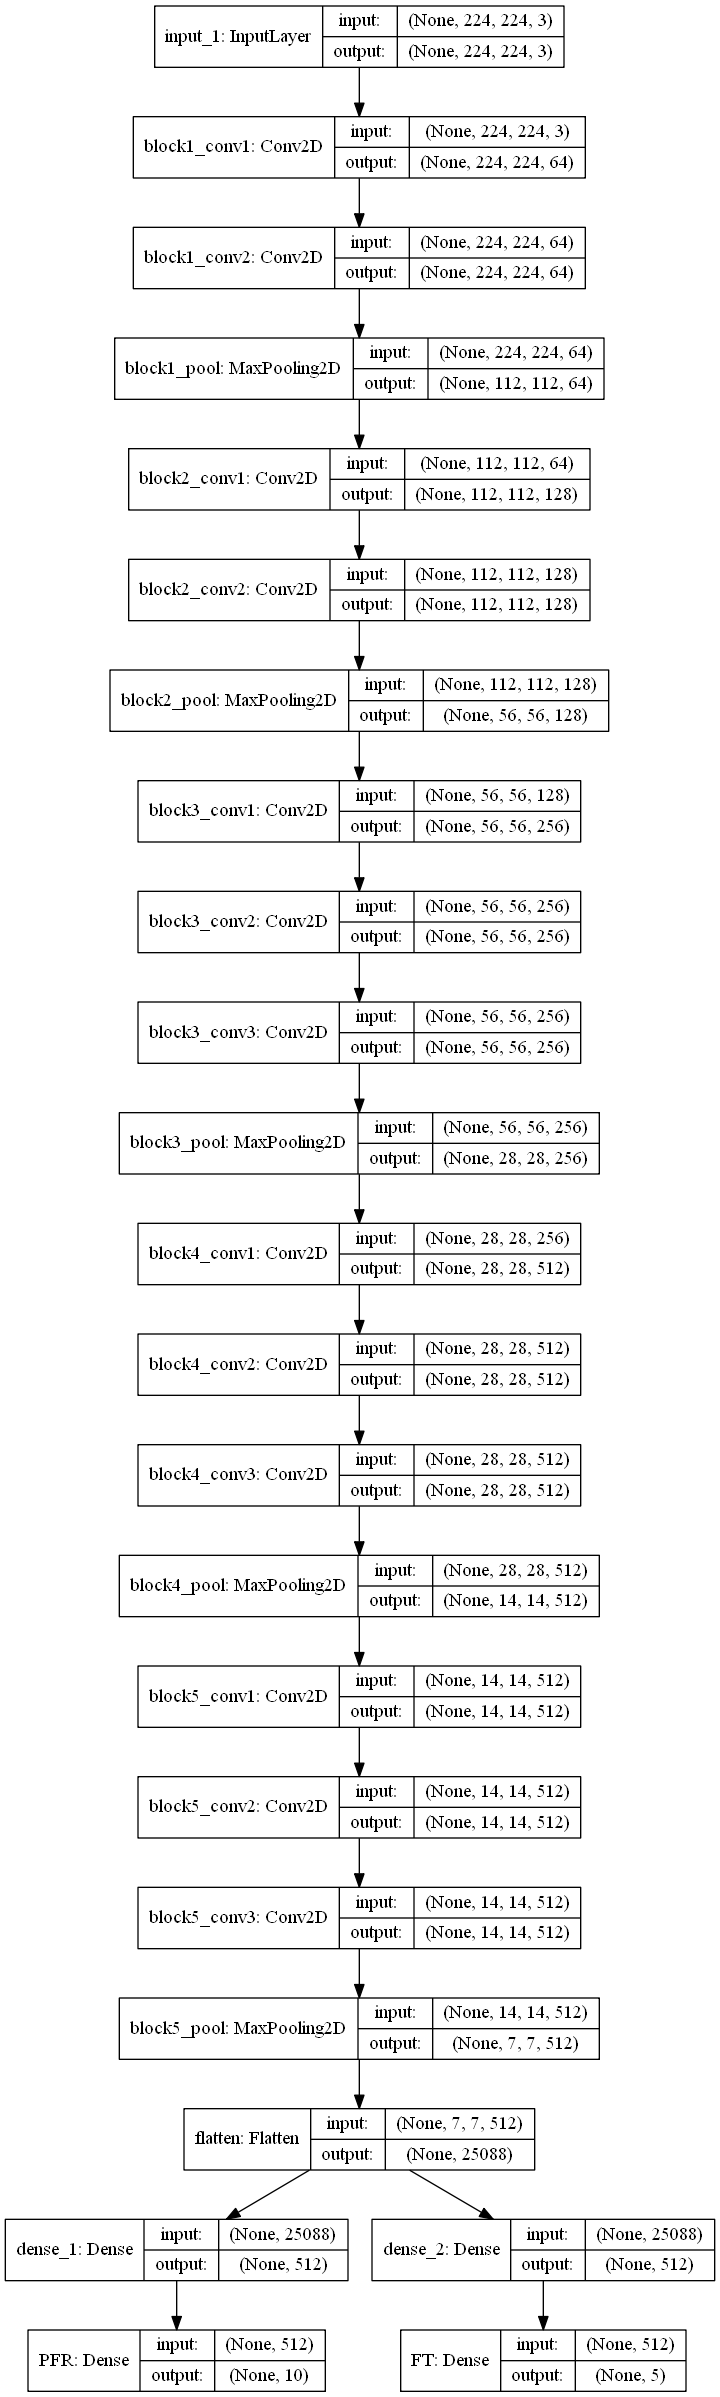

In [7]:
plot_model(model3, show_shapes=True, show_layer_names=True)

In [8]:
losses = {
    "PFR": "categorical_crossentropy",
    "FT": "categorical_crossentropy",
}

metric = {
    "PFR":'accuracy',
    "FT": "accuracy",
}
lossWeights = {"PFR": 10.0, "FT": 1.0}
opt = SGD(lr=1e-5, momentum=0.8)
model3.compile(optimizer=opt,loss=losses,
               loss_weights=lossWeights,
               metrics=metric)

In [9]:
cols = ['Image','PFRType','FuelType','dir']
labels = labels[cols]

In [10]:
pfr_label_encoder = LabelEncoder()
pfr_label_encoder.fit(labels.PFRType)
pfrEncoded = pfr_label_encoder.transform(labels.PFRType)

ft_label_encoder = LabelEncoder()
ft_label_encoder.fit(labels.FuelType)
ftEncoded = ft_label_encoder.transform(labels.FuelType)

labels.PFRType = pfrEncoded
labels.FuelType = ftEncoded


In [11]:
labels.Image = labels.Image.astype(str)+'.jpg'
labels.head()

,Image,PFRType,FuelType,dir
0,3110_32.jpg,5,0,train
1,3227_27.jpg,0,1,train
2,3197_23.jpg,0,0,train
3,3320_2.jpg,1,3,vald
4,3157_33.jpg,2,4,test


In [12]:
# trying flow from dataframe

In [13]:
trainGen = ImageDataGenerator()
trainGenDf = trainGen.flow_from_dataframe(dataframe=labels[labels.dir == 'train'],
                                         directory = '../MTLData/train/',
                                         x_col = "Image",y_col=["PFRType","FuelType"],
                                         class_mode='multi_output',
                                         target_size=(224,224),
                                         batch_size=32)
valdGen = ImageDataGenerator()
valdGenDf = valdGen.flow_from_dataframe(dataframe=labels[labels.dir == 'vald'],
                                         directory = '../MTLData/vald/',
                                         x_col = "Image",y_col=["PFRType","FuelType"],
                                         class_mode='multi_output',
                                         target_size=(224,224),
                                         batch_size=32)
testGen = ImageDataGenerator()
testGenDf = valdGen.flow_from_dataframe(dataframe=labels[labels.dir == 'test'],
                                         directory = '../MTLData/test/',
                                         x_col = "Image",y_col=["PFRType","FuelType"],
                                         class_mode='multi_output',
                                         target_size=(224,224),
                                         batch_size=32)

Found 7309 validated image filenames.
Found 1556 validated image filenames.
Found 1554 validated image filenames.


In [14]:
STEP_SIZE_TRAIN=trainGenDf.n//batch_size
STEP_SIZE_VALID=valdGenDf.n//batch_size
STEP_SIZE_TEST=testGenDf.n//batch_size

In [17]:
class CustonGen:
    def __init__(self):
        self.trainClsPfr, self.trainClsFt = [],[]
        self.testClsPfr, self.testClsFt = [],[]
        self.valdClsPfr, self.valdClsFt = [],[]
    
    def get_data_generator(self, data, split ,batch_size=16):

        imagePath = ''
        df =''

        if split == 'train':
            imagePath = '../MTLData/train/'
            df = data[data.dir == 'train']
            self.trainStep = df.shape[0]//batch_size
        elif split == 'test':
            imagePath = '../MTLData/test/'
            df = data[data.dir == 'test']
            self.testStep = df.shape[0]//batch_size
        elif split == 'vald':
            imagePath = '../MTLData/vald/'
            df = data[data.dir == 'vald']
            self.valdStep = df.shape[0]//batch_size

        pfrID = len(data.PFRType.unique())
        ftID = len(data.FuelType.unique())
        images, pfrs,fts = [], [], []
        while True:
            for i in range(0,df.shape[0]):
                r = df.iloc[i]
                file, pfr, ft = r['Image'], r['PFRType'], r['FuelType']
                im = Image.open(imagePath+file)
                im = im.resize((224, 224))
                im = np.array(im) / 255.0
                images.append(im)

                if split == 'train':
                    self.trainClsPfr.append(pfr)
                    self.trainClsFt.append(ft)
                elif split == 'vald':
                    self.valdClsPfr.append(pfr)
                    self.valdClsFt.append(ft)
                elif split == 'test':
                    self.testClsPfr.append(pfr)
                    self.testClsFt.append(ft)
                    
                pfrs.append(to_categorical(pfr, pfrID))
                fts.append(to_categorical(ft, ftID))
                
                if len(images) >= batch_size:
                    yield np.array(images), [np.array(pfrs), np.array(fts)]
                    images, pfrs, fts = [], [], []
generator = CustonGen()

In [18]:
H = model3.fit_generator(generator=get_data_generator(labels,'train',batch_size),
                    steps_per_epoch=STEP_SIZE_TRAIN+1,
                    validation_data=get_data_generator(labels,'vald',batch_size),
                    validation_steps=STEP_SIZE_VALID+1,
                    epochs=EPOCHS
)

NameError: name 'get_data_generator' is not defined

In [19]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',patience=10, mode='min', verbose=1)

In [20]:
# Using generator Class
H = model3.fit_generator(generator=generator.get_data_generator(labels,'train',batch_size),
                    steps_per_epoch=STEP_SIZE_TRAIN+1,
                    validation_data=generator.get_data_generator(labels,'vald',batch_size),
                    validation_steps=STEP_SIZE_VALID+1,
                    epochs=EPOCHS,
                    callbacks=[es]
)

Epoch 1/80
115/115 [==============================] - 134s 1s/step - loss: 16.0819 - PFR_loss: 1.4751 - FT_loss: 1.3309 - PFR_accuracy: 0.5380 - FT_accuracy: 0.4505 - val_loss: 14.1193 - val_PFR_loss: 1.1827 - val_FT_loss: 1.2040 - val_PFR_accuracy: 0.5913 - val_FT_accuracy: 0.4850
Epoch 2/80
115/115 [==============================] - 125s 1s/step - loss: 10.1477 - PFR_loss: 0.9155 - FT_loss: 0.9922 - PFR_accuracy: 0.6917 - FT_accuracy: 0.6562 - val_loss: 7.6382 - val_PFR_loss: 0.6524 - val_FT_loss: 0.7673 - val_PFR_accuracy: 0.7887 - val_FT_accuracy: 0.7538
Epoch 3/80
115/115 [==============================] - 126s 1s/step - loss: 5.5381 - PFR_loss: 0.5024 - FT_loss: 0.5139 - PFR_accuracy: 0.8223 - FT_accuracy: 0.8504 - val_loss: 4.8036 - val_PFR_loss: 0.4016 - val_FT_loss: 0.3800 - val_PFR_accuracy: 0.8556 - val_FT_accuracy: 0.8831
Epoch 4/80
115/115 [==============================] - 124s 1s/step - loss: 3.6511 - PFR_loss: 0.3379 - FT_loss: 0.2722 - PFR_accuracy: 0.8793 - FT_accurac

## Evaluate

In [1]:
filename = 'Model_loss_ES_40Ep'
pngExt = '.png'
jsonExt = '.json'
h5Ext = '.h5'

In [2]:
def  plot_train_history(history):
    fig, axes = plt.subplots(2, 3, figsize=(20, 5))
    axes[0][0].plot(history.history['PFR_accuracy'], label='PFR Train accuracy')
    axes[0][0].plot(history.history['val_PFR_accuracy'], label='PFR Val accuracy')
    axes[0][0].set_xlabel('Epochs')
    axes[0][0].legend()
    
    axes[0][1].plot(history.history['FT_accuracy'], label='FT Train accuracy')
    axes[0][1].plot(history.history['val_FT_accuracy'], label='FT Val accuracy')
    axes[0][1].set_xlabel('Epochs')
    axes[0][1].legend()

    axes[1][2].plot(history.history['loss'], label='Training loss')
    axes[1][2].plot(history.history['val_loss'], label='Validation loss')
    axes[1][2].set_xlabel('Epochs')
    axes[1][2].legend()
    
    axes[1][0].plot(history.history['PFR_loss'], label='PFR Training loss')
    axes[1][0].plot(history.history['val_PFR_loss'], label=' PFR Validation loss')
    axes[1][0].set_xlabel('Epochs')
    axes[1][0].legend()
    
    axes[1][1].plot(history.history['FT_loss'], label='FT Training loss')
    axes[1][1].plot(history.history['val_FT_loss'], label=' FT Validation loss')
    axes[1][1].set_xlabel('Epochs')
    axes[1][1].legend()
    plt.savefig('../Models/MTL/'+filename+pngExt)

plot_train_history(H)

NameError: name 'H' is not defined

In [23]:
def save_model(model,path,h5Name,jsonName):
    model.save_weights(path+h5Name)
    with open(path+jsonName, 'w') as f:
        f.write(model.to_json())
        
def load_model(path, h5Name,jsonName):
    from keras.models import model_from_json
    with open(path+jsonName, 'r') as f:
        model = model_from_json(f.read())
    model.load_weights(path+h5Name)
    
    return model

In [24]:

h5Name = filename+h5Ext
jsonName = filename+jsonExt
path = '../Models/MTL/'

In [25]:

save_model(model3,path,h5Name,jsonName)

In [26]:
model = load_model(path,h5Name,jsonName)

In [27]:
STEP_SIZE_TEST

24

In [28]:
test_gen = generator.get_data_generator(labels,'test',batch_size)
x_test, (pfr_true, ft_true)= next(test_gen,1600)
pfr_pred, ft_pred = model3.predict_on_batch(x_test)

In [29]:
pfr_true, ft_true = pfr_true.argmax(axis=-1), ft_true.argmax(axis=-1)
pfr_pred, ft_pred = pfr_pred.argmax(axis=-1), ft_pred.argmax(axis=-1)

In [30]:
from sklearn.metrics import classification_report
print("Classification report for PFR")
print(classification_report(pfr_true, pfr_pred))

print("\nClassification report for FT")
print(classification_report(ft_true, ft_pred))

Classification report for PFR
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00         1
           2       1.00      0.89      0.94         9
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         1

    accuracy                           0.98        64
   macro avg       0.97      0.99      0.97        64
weighted avg       0.99      0.98      0.99        64


Classification report for FT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.88      1.00      0.93        14
           2      

In [ ]:
# COnfusion Matrix Train

In [31]:
gen2 = CustonGen()
from sklearn.metrics import confusion_matrix

In [32]:
pfr,ft = model3.predict_generator(gen2.get_data_generator(labels,'train',batch_size), STEP_SIZE_TRAIN+1)
pfr,ft  = pfr.argmax(axis=-1), ft.argmax(axis=-1)
trupfr = gen2.trainClsPfr[0:pfr.shape[0]]
truft = gen2.trainClsFt[0:ft.shape[0]]

print('Confusion Matrix for pfr')
print(confusion_matrix(trupfr, pfr))

print('Confusion Matrix for ft')
print(confusion_matrix(truft, ft))

Confusion Matrix for pfr
[[4012    0    0    0    0    0    0    0    0    0]
 [  43  315    6    0    0    0    5    0    0    0]
 [   0    1  675    5    0    0    0    0    1    0]
 [   0    0    0  216    0    0    0    0    0    0]
 [   0    0    0    0  304    0    0    0    0    0]
 [   0    0    0    0    0  273    0    7    0    0]
 [   0    1    0    0    0    0  489    0    0    0]
 [   0    0    0    0    0    0    0  125    0    0]
 [   0    0    0    0    0    0   24    0  698    0]
 [   0    0    0    0    0    0    0    0    0  160]]
Confusion Matrix for ft
[[1644    0    0    0    0]
 [   0 1315    0    0   17]
 [   4    0  191    0    0]
 [   0    0    0  755    0]
 [   0   36    0    0 3398]]


In [ ]:
# on vald

In [33]:
pfr,ft = model3.predict_generator(gen2.get_data_generator(labels,'vald',batch_size), STEP_SIZE_VALID+1)
pfr,ft  = pfr.argmax(axis=-1), ft.argmax(axis=-1)
trupfr = gen2.valdClsPfr[0:pfr.shape[0]]
truft = gen2.valdClsFt[0:ft.shape[0]]

print('Confusion Matrix for pfr')
print(confusion_matrix(trupfr, pfr))

print('Confusion Matrix for ft')
print(confusion_matrix(truft, ft))

Confusion Matrix for pfr
[[872   0   0   0   0   0   0   0   0   0]
 [  9  79   3   0   0   0   3   0   0   0]
 [  0   0 167   8   0   0   0   0   1   0]
 [  0   0   3  40   0   0   0   0   0   0]
 [  0   0   0   2  60   0   0   0   0   0]
 [  0   0   0   0   0  44   0   1   0   0]
 [  3   1   0   0   0   0 102   0   1   0]
 [  0   0   0   0   0   0   0  19   0   0]
 [  0   0   3   0   0   0   9   0 142   0]
 [  0   0   0   0   0   1   0   0   0  27]]
Confusion Matrix for ft
[[349   0   0   0   0]
 [  0 281   0   0   7]
 [  4   0  44   0   0]
 [  0   0   0 177   0]
 [  0   9   0   0 729]]


In [34]:
pfr,ft = model3.predict_generator(gen2.get_data_generator(labels,'test',batch_size), STEP_SIZE_TEST+1)
pfr,ft  = pfr.argmax(axis=-1), ft.argmax(axis=-1)
trupfr = gen2.testClsPfr[0:pfr.shape[0]]
truft = gen2.testClsFt[0:ft.shape[0]]

print('Confusion Matrix for pfr')
print(confusion_matrix(trupfr, pfr))

print('Confusion Matrix for ft')
print(confusion_matrix(truft, ft))

Confusion Matrix for pfr
[[875   0   0   0   0   0   0   0   0   0]
 [ 10  48   3   0   0   0   2   0   0   0]
 [  0   0 177  10   0   0   0   0   4   0]
 [  0   0   4  43   0   0   0   0   0   0]
 [  0   0   0   0  66   0   0   0   0   0]
 [  0   0   0   0   0  49   0   2   0   1]
 [  2   2   0   0   0   0  87   0   1   0]
 [  0   0   0   0   0   0   0  18   0   0]
 [  0   1   0   0   0   0  16   0 144   0]
 [  0   0   0   0   0   0   0   0   0  35]]
Confusion Matrix for ft
[[356   0   0   0   0]
 [  0 326   0   0   2]
 [  2   0  44   0   2]
 [  0   0   0 137   0]
 [  0   9   0   0 722]]


In [ ]:
cm = confusion_matrix(truft, ft)
cm

In [ ]:
cmd = pd.DataFrame(cm)

In [ ]:
cmd